In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

### Train a regression to predict Top-Botton K with varying K

In [2]:
k_list = [1000, 1250, 1500, 1750, 2000, 2500, 5000, 7500, 10000, 15000]

wl = ['Culture.Biography.Biography*',
               'Culture.Food and drink', 'Culture.Internet culture', 'Culture.Linguistics',
               'Culture.Literature', 'Culture.Media.Books', 'Culture.Media.Entertainment',
               'Culture.Media.Films', 'Culture.Media.Music', 'Culture.Media.Radio',
               'Culture.Media.Software', 'Culture.Media.Television', 'Culture.Media.Video games',
               'Culture.Performing arts', 'Culture.Philosophy and religion', 'Culture.Sports',
               'Culture.Visual arts.Architecture', 'Culture.Visual arts.Comics and Anime',
               'Culture.Visual arts.Fashion', 'Geography.Geographical',
                'Geography.Regions.Africa.Central Africa',
               'Geography.Regions.Africa.Eastern Africa', 'Geography.Regions.Africa.Northern Africa',
               'Geography.Regions.Africa.Southern Africa', 'Geography.Regions.Africa.Western Africa',
               'Geography.Regions.Americas.Central America', 'Geography.Regions.Americas.North America',
               'Geography.Regions.Americas.South America', 
               'Geography.Regions.Asia.Central Asia', 'Geography.Regions.Asia.East Asia',
               'Geography.Regions.Asia.North Asia', 'Geography.Regions.Asia.South Asia',
               'Geography.Regions.Asia.Southeast Asia', 'Geography.Regions.Asia.West Asia',
               'Geography.Regions.Europe.Eastern Europe', 
               'Geography.Regions.Europe.Northern Europe', 'Geography.Regions.Europe.Southern Europe',
               'Geography.Regions.Europe.Western Europe', 'Geography.Regions.Oceania',
               'History and Society.Business and economics', 'History and Society.Education',
               'History and Society.History', 'History and Society.Military and warfare',
               'History and Society.Politics and government', 'History and Society.Society',
               'History and Society.Transportation', 'STEM.Biology', 'STEM.Chemistry',
               'STEM.Computing', 'STEM.Earth and environment', 'STEM.Engineering', 'STEM.Libraries & Information',
               'STEM.Mathematics', 'STEM.Medicine & Health', 'STEM.Physics', 
               'STEM.Space', 'STEM.Technology']


coeff_list = []
for TOPK in k_list:
    balanced = pd.read_pickle("features_balanced_{}.pkl".format(TOPK))[['page_id', 'high']]

    expanded_features = pd.read_pickle("page_topics_ctrate_expanded.pkl")\
                .drop_duplicates().merge(balanced, on="page_id")
    expanded_features.head()
    X = pd.DataFrame()

    # standardization
    for f in wl:
        X[f] = (expanded_features[f]-expanded_features[f].mean())/expanded_features[f].std()

    y = expanded_features[['ctrate']]

    m = np.median(y.ctrate)

    mod = sm.Logit([1 if i >=m else 0 for i in y.ctrate ], sm.add_constant(X))
    res = mod.fit()
    
    print("K={}, Pseudo R-squ.: {}".format(TOPK, res.prsquared))
    
    err_series = res.params - res.conf_int()[0]

    coef_df = pd.DataFrame({'coef': res.params.values[1:],
                            'err': err_series.values[1:],
                            'varname': err_series.index.values[1:],
                            'k': TOPK
                           }).sort_values("coef", ascending=False)
    
    coeff_list.append(coef_df)

Optimization terminated successfully.
         Current function value: 0.375595
         Iterations 9
K=1000, Pseudo R-squ.: 0.4581308641738907
Optimization terminated successfully.
         Current function value: 0.392843
         Iterations 8
K=1250, Pseudo R-squ.: 0.43324799219663934
Optimization terminated successfully.
         Current function value: 0.395712
         Iterations 8
K=1500, Pseudo R-squ.: 0.42910887874187864
Optimization terminated successfully.
         Current function value: 0.398105
         Iterations 8
K=1750, Pseudo R-squ.: 0.4256564030987362
Optimization terminated successfully.
         Current function value: 0.401699
         Iterations 8
K=2000, Pseudo R-squ.: 0.42047033528333166
Optimization terminated successfully.
         Current function value: 0.415131
         Iterations 8
K=2500, Pseudo R-squ.: 0.40109237307740275
Optimization terminated successfully.
         Current function value: 0.429746
         Iterations 7
K=5000, Pseudo R-squ.: 0.38000

Plot all topics coefficients distribution:

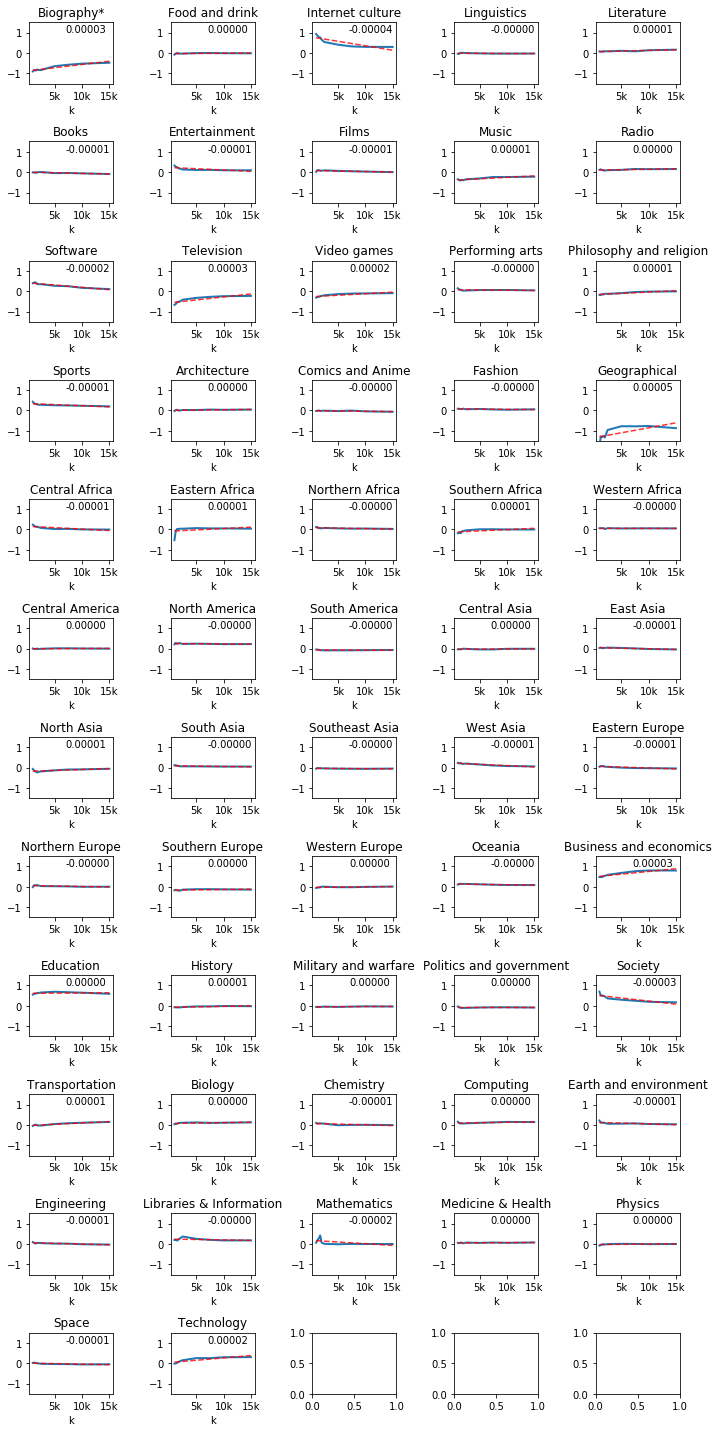

In [3]:
columns = 5

fig, ax = plt.subplots(12, columns, figsize=(10, 20))

c_list = pd.concat(coeff_list)
for n in range(0, len(wl)):
    var = wl[n]
    c_ax = ax[n//columns][n%columns]
    
    df = c_list[c_list.varname==var].sort_values("k")
    c_ax = df.plot(x="k", y="coef", title=var.split(".")[-1], ax=c_ax, linewidth=2)

    m, b = np.polyfit(df.k, df.coef, 1)
    c_ax.plot(df.k, m*df.k + b, alpha=0.8, linestyle="--", c="r")
    c_ax.text(7000, 1, "{:.5f}".format(m))
    
    c_ax.set_ylim((-1.5,1.5))
    c_ax.legend().remove()
    c_ax.set_xticklabels([0, 5000, 10000, 15000])
    c_ax.set_xticklabels(["0", "5k", "10k", "15k"])
    
plt.tight_layout()


Plot the topics sorted by the value of the first coefficient: k=1000

Text(0.5, -0.0, 'Top L links w.r.t. CTR')

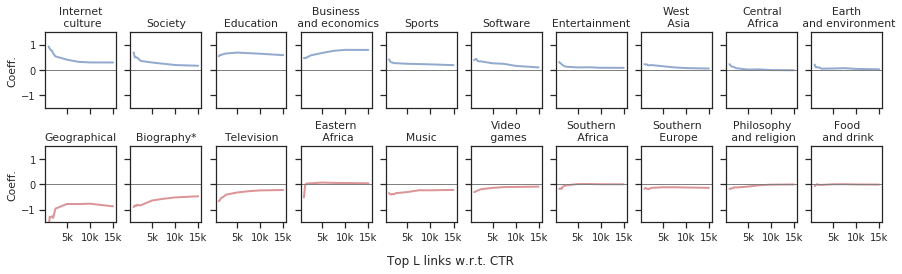

In [4]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 0.9)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 1
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


df = pd.concat(coeff_list)

diffs = []
for v in wl:
    first = df[(df.varname==v)&(df.k==1000)].coef.iloc[0]
    last = df[(df.varname==v)&(df.k==15000)].coef.iloc[0]
    diffs.append({"varname": v, "first": first})
    
diffs = pd.DataFrame(diffs).sort_values("first")

c_list = pd.concat(coeff_list).merge(diffs, on="varname").sort_values("first")
top_bottom = c_list.head(100).append(c_list.tail(100)).sort_values("first", ascending=False)

columns = 10

fig, ax = plt.subplots(2, columns, figsize=(15, 3.5), sharey=True, sharex=True)

names = ['Culture.Internet culture',
 'History and Society.Society',
 'History and Society.Education',
 'History and Society.Business and economics',
 'Culture.Sports',
 'Culture.Media.Software',
 'Culture.Media.Entertainment',
 'Geography.Regions.Asia.West Asia',
 'Geography.Regions.Africa.Central Africa',
 'STEM.Earth and environment',
 'Geography.Geographical',
 'Culture.Biography.Biography*',
 'Culture.Media.Television',
 'Geography.Regions.Africa.Eastern Africa',
 'Culture.Media.Music',
 'Culture.Media.Video games',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Europe.Southern Europe',
 'Culture.Philosophy and religion',
 'Culture.Food and drink']


 

for n in range(0, len(names)):
    var = names[n]
    c_ax = ax[n//columns][n%columns]
    current = c_list[c_list.varname==var].copy()
    title = var.split(".")[-1]
    if title.find(' ')>-1:
        title=title[:title.find(' ')]+"\n"+title[title.find(' '):]
    
    if n//columns==0:
        color = 'b'
    else:
        color = 'r'
    current.sort_values("k").plot(x="k", y="coef", linewidth=2,
                             title=title, ax=c_ax, color=color, alpha=0.6)
    df = top_bottom[top_bottom.varname==var]

    c_ax.axhline(y=0, linestyle='-', color='grey', linewidth=1)

    c_ax.set_ylim((-1.5,1.5))
    c_ax.legend().remove()
    c_ax.set_xlabel("")
    c_ax.set_ylabel("Coeff.")
    c_ax.set_xticklabels([0, 5000, 10000, 15000])
    c_ax.set_xticklabels(["0", "5k", "10k", "15k"])
    
plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig.suptitle("Top L links w.r.t. CTR", fontsize=12, y=-0.0)

# plt.savefig('coeff_different_k_sort1000.pdf', bbox_inches='tight')